In [1]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import copy
import os

from collections import defaultdict
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from scipy.stats import describe, kstest, mannwhitneyu, sem
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis import plot, util

In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 14})

In [3]:
"""Set torch device."""

# device = t.device("cpu")  # small toy models may be faster via cpu
device = t.device("cuda" if t.cuda.is_available() else "cpu")
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


In [4]:
sns.set_style("whitegrid")

plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["legend.title_fontsize"] = 13

## Training the models

In [5]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x) + x

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

In [6]:
feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
target_integral = 1/3  # 1/3 is integral of (relu(x))**2 from -1 to 1
interval_length = 2  # from -1 to 1
neuron_feature_ratio = 0.5
naive_loss = target_integral / interval_length * neuron_feature_ratio * feat_prob
print(f"naive loss: {naive_loss:.2e}")

naive loss: 8.33e-03


In [7]:
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10
n_feat=20
n_hidden=10

# 20-10 with ER-10

noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 0.5,
    "r": n_hidden,
    "learned": True
}
cis_rr10_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr10 = Cis(cis_rr10_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr10.parameters(), lr=1e-3)
_losses = train(
    model=cis_rr10,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
# 20-10 with enforced-sv-10

noise_params = {
    "matrix_type": "enforced_sv",
    "noise_coeff": 0.05,
    "r": n_hidden,
    "learned": False
}
cis_esv10_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_esv10 = Cis(cis_esv10_cfg, device=device).to(device)
optimizer = optim.Adam(cis_esv10.parameters(), lr=1e-3)
_losses = train(
    model=cis_esv10,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
rr_10_eval_loss = eval_model(
    model=cis_rr10,
    batch_sz=1_000_000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
).mean().item()

esv_10_eval_loss = eval_model(
    model=cis_esv10,
    batch_sz=1_000_000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
).mean().item()

print(f"rr-10 eval loss: {rr_10_eval_loss:.2e}")
print(f"esv-10 eval loss: {esv_10_eval_loss:.2e}")

rr-10 eval loss: 6.58e-03
esv-10 eval loss: 7.87e-03


 ### Asymmetric noise base

 ### `rank = nfeat` symmetric noise base

 ### `rank = (nfeat / 2)` symmetric noise base

 ### `rank = 2` symmetric noise base

 ### `rank = 1` symmetric noise base

In [ ]:
"""Set up and train models."""

layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10
n_feat=20
n_hidden=10

naive loss: 8.33e-03


In [30]:
# asymmetric-normal, noise_var=0.05
noise_params = {
    "matrix_type": "asymmetric",
    "noise_coeff": 0.05,
}
cis_asym_norm_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_asym_norm = Cis(cis_asym_norm_cfg, device=device).to(device)
optimizer = optim.Adam(cis_asym_norm.parameters(), lr=1e-3)
_losses = train(
    model=cis_asym_norm,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
eval_losses = eval_model(
    cis_asym_norm, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 7.73e-03


In [33]:
# symmetric-normal, noise_var=0.05
noise_params = {
    "matrix_type": "symmetric",
    "noise_coeff": 0.05,
}
cis_sym_norm_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_sym_norm = Cis(cis_sym_norm_cfg, device=device).to(device)
optimizer = optim.Adam(cis_sym_norm.parameters(), lr=1e-3)
_losses = train(
    model=cis_sym_norm,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
eval_losses = eval_model(
    cis_sym_norm, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 7.33e-03


In [22]:
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 1024
n_steps = 10000
logging_freq = n_steps // 10
n_feat=100
n_hidden=50
noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 0.5,
    "r": n_feat,
    "learned": True
}

cis_rr100_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr100 = Cis(cis_rr100_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr100.parameters(), lr=1e-3)

_losses = train(
    model=cis_rr100,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
eval_losses = eval_model(
    cis_rr100, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 8.14e-03


In [16]:
8.08e-3, 8.08e-3,

(0.00808,)

In [74]:
U = t.randn(3, n_feat)
t.linalg.qr(U, "complete")

torch.return_types.linalg_qr(
Q=tensor([[-0.2331,  0.8899,  0.3922],
        [ 0.2417, -0.3377,  0.9097],
        [ 0.9420,  0.3068, -0.1364]]),
R=tensor([[-1.5156,  1.5688, -1.2160,  0.8910,  2.1212],
        [ 0.0000,  0.8704,  0.5220,  1.7593,  1.4644],
        [ 0.0000,  0.0000, -0.0282, -0.9605,  0.2668]]))

In [ ]:
n_feat, r, alpha = 5, 2, 0.5
I = t.eye(n_feat)
U = t.randn(n_feat, r)
Q, _ = t.linalg.qr(U, mode="reduced")
I += alpha * (Q @ Q.T)

In [399]:
Q, _ = t.linalg.qr(t.randn(20, 5), mode="reduced")  # 20×5 orthonormal
QQ = Q @ Q.T            # projection, rank 5, trace = 5
QQ.fill_diagonal_(0.0)  # make the trace 0
W  = t.eye(20) + QQ * 10 # symmetric, full-rank, σ spread is tiny
effective_rank(W)

12.440629959106445

<Axes: >

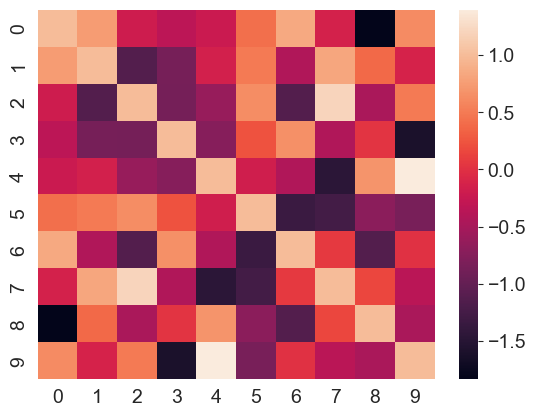

In [363]:
sns.heatmap(t.eye(10) + QQ * 5)

In [369]:
effective_rank((QQ * 5).fill_diagonal_(1.0))

8.094137191772461

<Axes: >

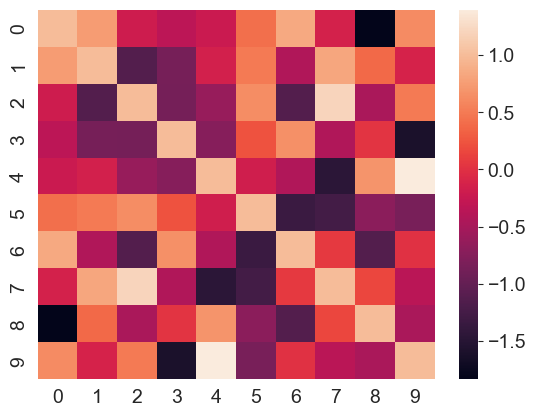

In [365]:
sns.heatmap((QQ * 5).fill_diagonal_(1.0))

In [65]:
t.linalg.qr(U, mode="complete")

torch.return_types.linalg_qr(
Q=tensor([[-0.1106, -0.0641,  0.6485, -0.4982,  0.5612],
        [ 0.0713, -0.1870, -0.4979,  0.2633,  0.8017],
        [ 0.7003, -0.4159,  0.4163,  0.4027, -0.0330],
        [-0.5245,  0.2010,  0.3948,  0.7198,  0.1024],
        [ 0.4660,  0.8646,  0.0488,  0.0464,  0.1753]]),
R=tensor([[ 1.2288, -0.0541],
        [ 0.0000,  1.4931],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]]))

In [66]:
t.linalg.qr(U)

torch.return_types.linalg_qr(
Q=tensor([[-0.1106, -0.0641],
        [ 0.0713, -0.1870],
        [ 0.7003, -0.4159],
        [-0.5245,  0.2010],
        [ 0.4660,  0.8646]]),
R=tensor([[ 1.2288, -0.0541],
        [ 0.0000,  1.4931]]))

In [63]:
Q

tensor([[-0.1106, -0.0641],
        [ 0.0713, -0.1870],
        [ 0.7003, -0.4159],
        [-0.5245,  0.2010],
        [ 0.4660,  0.8646]])

In [62]:
t.sum(Q[:,0]**2)

tensor(1.0000)

In [56]:
Q @ Q.T

tensor([[ 0.0163,  0.0041, -0.0508,  0.0452, -0.1070],
        [ 0.0041,  0.0400,  0.1277, -0.0750, -0.1285],
        [-0.0508,  0.1277,  0.6634, -0.4509, -0.0332],
        [ 0.0452, -0.0750, -0.4509,  0.3155, -0.0706],
        [-0.1070, -0.1285, -0.0332, -0.0706,  0.9647]])

In [57]:
Q.T @ Q

tensor([[1.0000e+00, 2.9802e-08],
        [2.9802e-08, 1.0000e+00]])

In [69]:
I += alpha * (Q @ Q.T)

In [70]:
I

tensor([[ 1.0082,  0.0020, -0.0254,  0.0226, -0.0535],
        [ 0.0020,  1.0200,  0.0638, -0.0375, -0.0642],
        [-0.0254,  0.0638,  1.3317, -0.2255, -0.0166],
        [ 0.0226, -0.0375, -0.2255,  1.1578, -0.0353],
        [-0.0535, -0.0642, -0.0166, -0.0353,  1.4824]])

In [ ]:
# r < n_neurons
noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": 5,
    "r": 2
}
cis_rr2_cfg = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_rr2 = Cis(cis_rr2_cfg, device=device).to(device)
optimizer = optim.Adam(cis_rr2.parameters(), lr=1e-3)
_losses = train(
    model=cis_rr2,
    batch_sz=batch_sz,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=n_steps,
    logging_freq=logging_freq,
    device=device,
)


In [ ]:
eval_losses = eval_model(
    cis_rr2, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 6.01e-03
naive loss: 8.33e-03


In [28]:
# - 2feature-1neuron: baseline
cis_simple_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)
cis_simple = Cis(cis_simple_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple,
    batch_sz=128,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=4000,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
eval_losses = eval_model(
    cis_simple, 
    batch_sz=10000,
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 8.14e-03
naive loss: 8.33e-03


In [36]:
# - 2feature-1neuron: symmetric-normal, noise_var=0.2
noise_params = {
    "matrix_type": "symmetric",
    "noise_coeff": 0.2,
}
cis_simple_sym_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_simple_sym = Cis(cis_simple_sym_cfg, device=device).to(device)
optimizer = optim.Adam(cis_simple_sym.parameters(), lr=1e-3)
_losses = train(
    model=cis_simple_sym,
    batch_sz=128,
    feat_sparsity=feat_sparsity,
    feat_importance=1.0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    n_steps=4000,
    logging_freq=logging_freq,
    device=device,
)


Training:   0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
eval_losses = eval_model(
    cis_simple_sym, 
    batch_sz=100000,  # 1000000 
    feat_sparsity=feat_sparsity,
    n_batches=100,
    device=device
)
print(f"eval loss: {eval_losses.mean().item():.2e}")

eval loss: 5.47e-03
naive loss: 8.33e-03


## Model Viz

In [12]:
# # models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2, cis_simple, cis_simple_sym]
# models = [cis_asym_norm, cis_sym_norm, cis_rr10]
# # model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2", "simple", "simple-sym"]
# model_names = ["asym-norm", "sym-norm", "rank-r-10"]

models = [cis_rr10, cis_esv10]
model_names = ["rank-r-10", "enforced-sv-10"]

In [38]:
x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)
relu_x_k = np.linalg.cond(asnumpy(relu_x.squeeze())).item()
print(f"{relu_x_k=:.3f}")
relu_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
sv_dict = {"relu": relu_sv}

for model, model_name in zip(models, model_names):
    # Get residual target values (res_target) for a test batch
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Get condition number of residual target.. 
    res_target_k = np.linalg.cond(asnumpy(res_target.squeeze())).item()
    print(f"{res_target_k=:.3f} : {model_name=}")

    # Get singular values of residual target.
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    sv_dict[model_name] = res_sv


relu_x_k=1.231
res_target_k=1.518 : model_name='asym-norm'
res_target_k=1.652 : model_name='sym-norm'
res_target_k=2.276 : model_name='rank-r-10'


### p=0.1

#### Performance across feature_probs

Testing across feature sparsities: 100%|██████████| 19/19 [00:01<00:00, 12.81it/s]


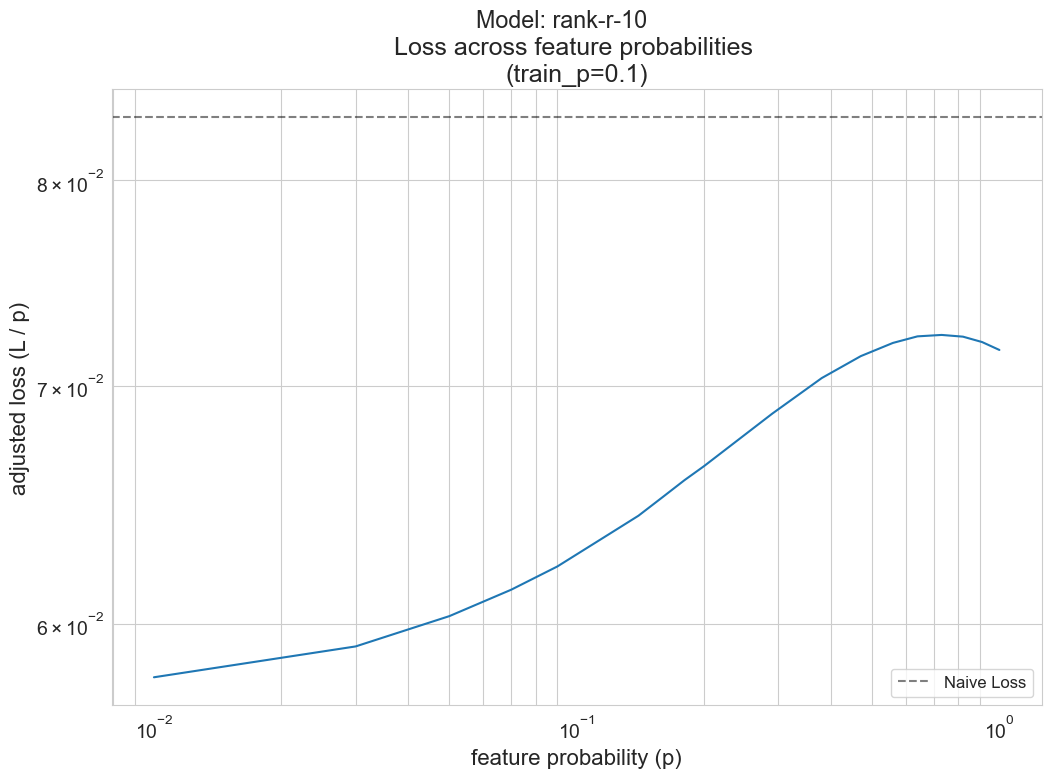

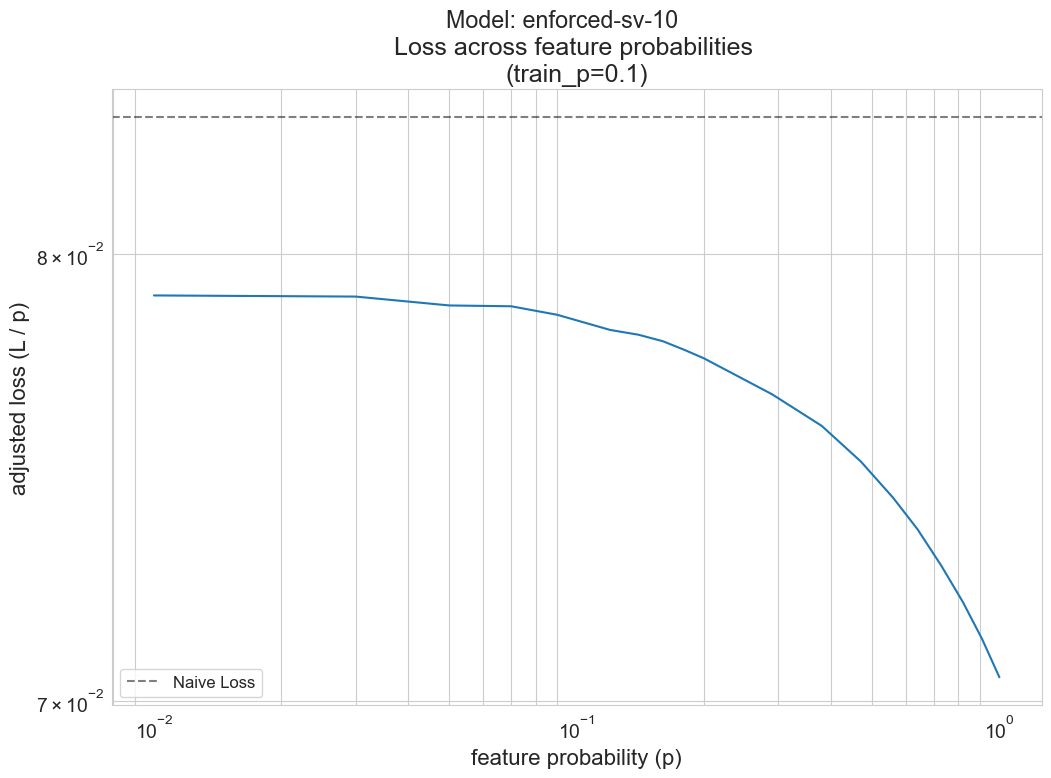

In [13]:
sparsity_low = np.round(np.linspace(0.0, 0.8, 10), 2)
sparsity_high = np.round(np.linspace(0.8, 0.99, 10), 2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))

for model, name in zip(models, model_names):
    ax, _ = plot.plot_loss_across_sparsities(
        sparsities=sparsities,
        model=model,
        eval_model=eval_model,
        train_sparsity=feat_sparsity,
    )
    ax.figure.suptitle(f"Model: {name}")
    ax.grid(which="both", axis="both")

#### Input-Output


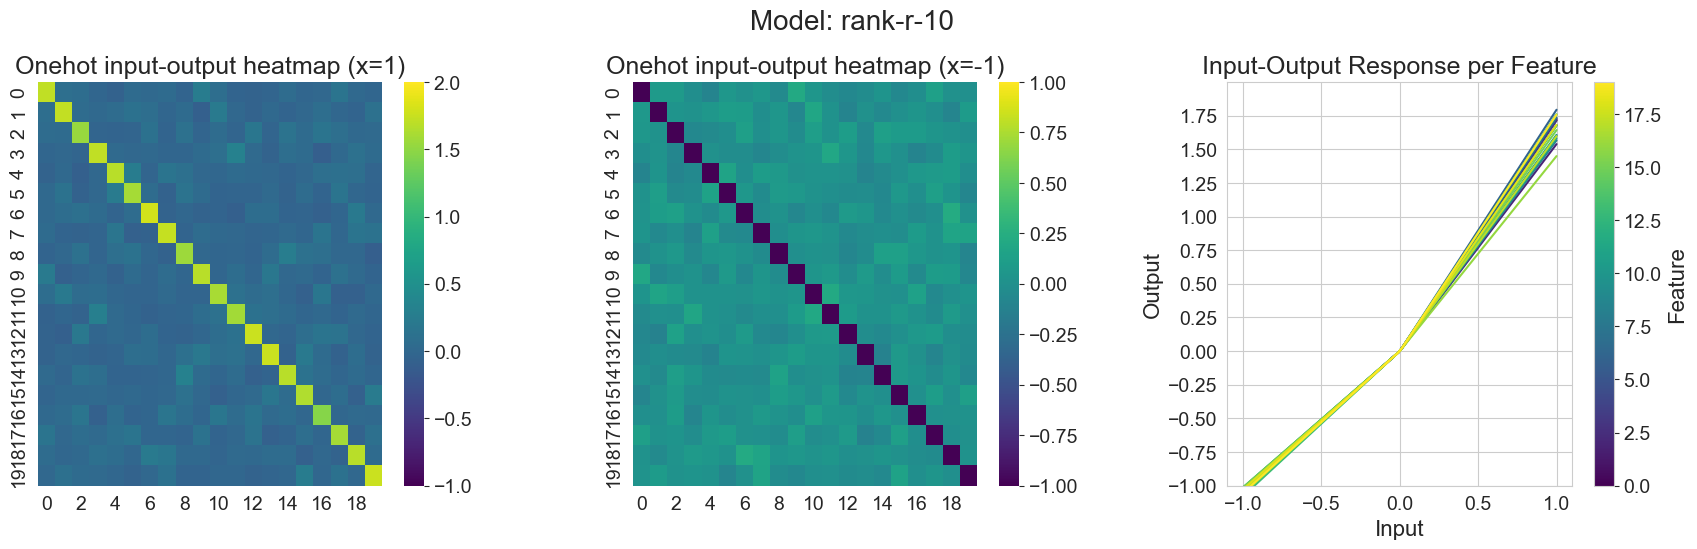

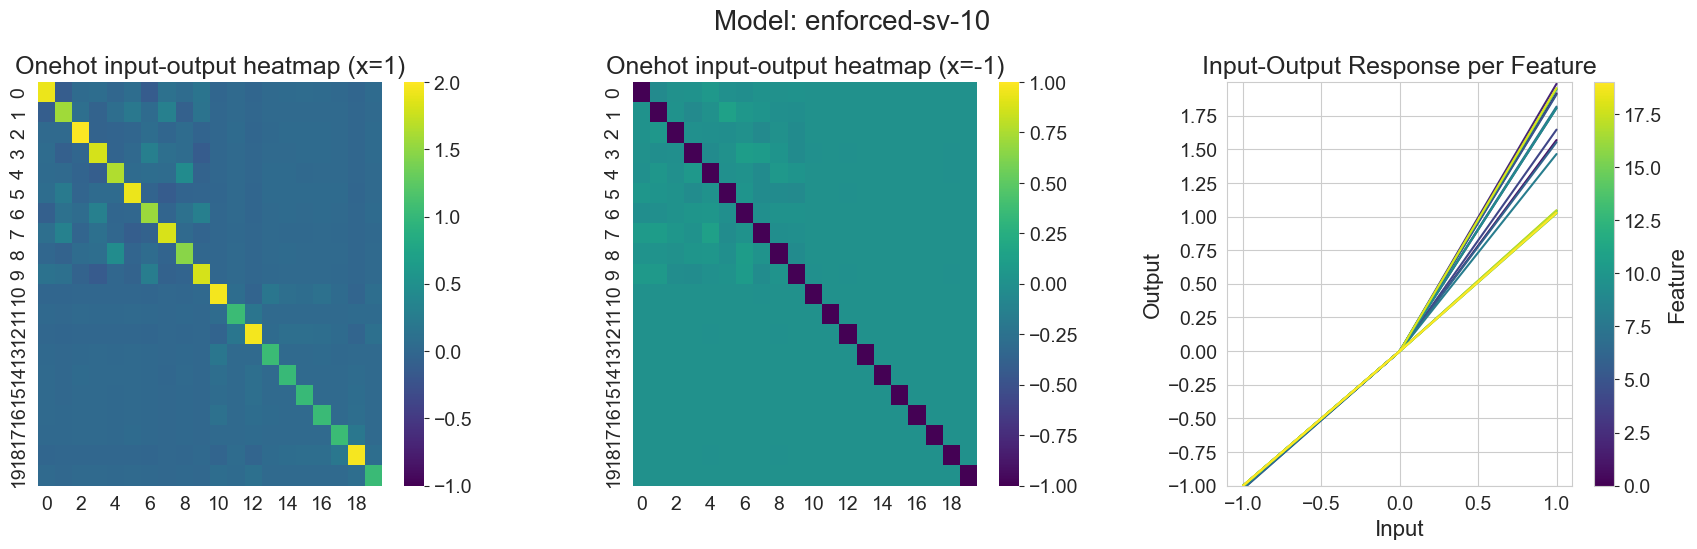

In [17]:
for model, model_name in zip(models, model_names):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    plot.plot_input_output_heatmap(1, model, ax=axs[0], annot=False, vmax=2)
    plot.plot_input_output_heatmap(-1, model, ax=axs[1], annot=False)
    x = t.linspace(-1, 1, 100, device=device)
    Y = util.in_out_response(model, x, device=device)
    plot.plot_input_output_response(Y, x, list(range(model.cfg.n_feat)), ax=axs[2])
    axs[2].set_ylim(-1, 2)
    axs[2].set_yticks(np.arange(-1, 2, 0.25))

    
    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

#### Weights


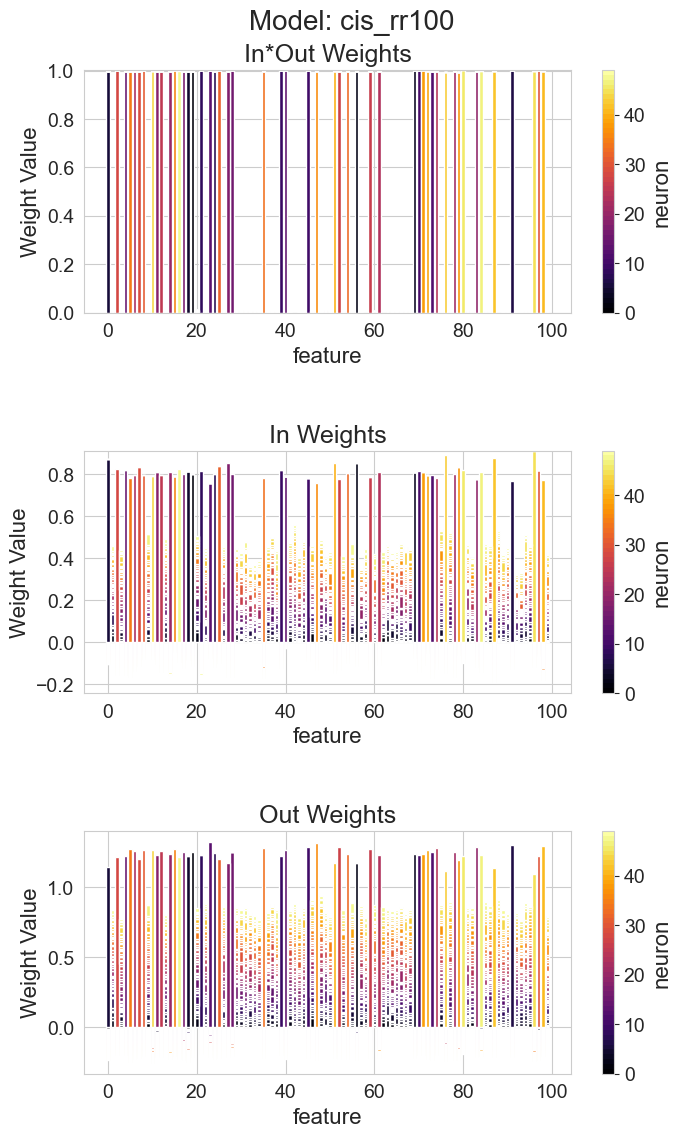

In [ ]:
for model, model_name in zip([cis_rr100], ["cis_rr100"):
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    W_adj = einsum(model.W1, model.W2, "inst dmlp feat, inst feat dmlp -> dmlp feat")
    W_adj = util.threshold_matrix(W_adj, threshold=0.001)
    plot.plot_weight_bars(W_adj, xax="feature", ax=axs[0])
    axs[0].set_title("In*Out Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W1.squeeze(), threshold=0.001), xax="feature", ax=axs[1]
    )
    axs[1].set_title("In Weights")
    plot.plot_weight_bars(
        util.threshold_matrix(model.W2.squeeze().T, threshold=0.001), xax="feature", ax=axs[2]
    )
    axs[2].set_title("Out Weights")

    fig.tight_layout(pad=3)
    fig.suptitle(f"Model: {model_name}", fontsize=20)

#### singular value spectra, condition number, and effective rank of $r(x)$

In [15]:
sns.set_style("white")

In [ ]:
x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)
relu_x_k = np.linalg.cond(asnumpy(relu_x.squeeze())).item()
print(f"{relu_x_k=:.3f}")
relu_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
sv_dict = {"relu": relu_sv}

for model, model_name in zip(models[:-2], model_names[:-2]):
    # Get residual target values (res_target) for a test batch
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Get condition number of residual target.
    res_target_k = np.linalg.cond(asnumpy(res_target.squeeze())).item()
    print(f"{res_target_k=:.3f} : {model_name=}")

    # Get singular values of residual target.
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    sv_dict[model_name] = res_sv


relu_x_k=1.807
res_target_k=1.968 : model_name='asym-norm'
res_target_k=2.402 : model_name='sym-norm'
res_target_k=2.463 : model_name='rank-r-10'
res_target_k=11.097 : model_name='rank-r-2'


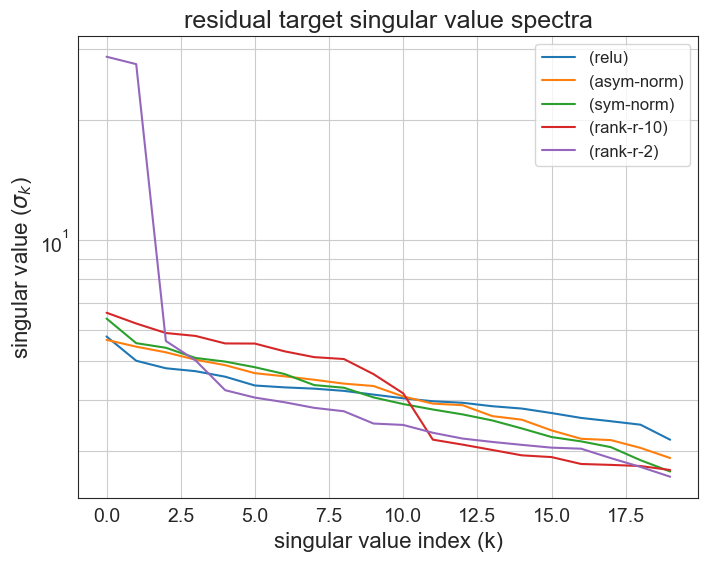

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, (model_name, sv_values) in enumerate(sv_dict.items()):
    ax.semilogy(
        asnumpy(sv_values), 
        label=f"({model_name})",
        # linestyle=linestyles[i % len(linestyles)],
        # color=colors[i % len(colors)]
    )

ax.set_xlabel("singular value index (k)")
ax.set_ylabel(r"singular value ($\sigma_k$)")
ax.set_title("residual target singular value spectra")
ax.legend()
ax.grid(which="both", axis="both")

# Expectation: steeper decay of singular values = effectively lower rank = easier to learn

#### Dot-products of $W_2$ neurons with $W_n$ eigenvectors


In [23]:
noise_base = t.tensor((
    (0, 1),
    (1, 0)
)).to(device)
noise_coeff = 0.5

feat_sparsity = 0.9
feat_prob = 1 - feat_sparsity
layer_act_fns = [t.relu, lambda x: x]
batch_sz = 128
n_steps = 3000
logging_freq = n_steps // 10
n_feat=2
n_hidden=1

target_integral = 1/3  # 1/3 is integral of (relu(x))**2 from -1 to 1
interval_length = 2
naive_loss = target_integral / interval_length * ((n_feat - n_hidden) / n_feat) * feat_prob

noise_params = {
    "matrix_type": "symmetric",
    "noise_coeff": noise_coeff,
    "learned": True
}
cis_simple_sym_cfg = CisConfig(
    n_instances=1,
    n_feat=2,
    n_hidden=1,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
cis_simple = Cis(cis_simple_sym_cfg, device=device).to(device)

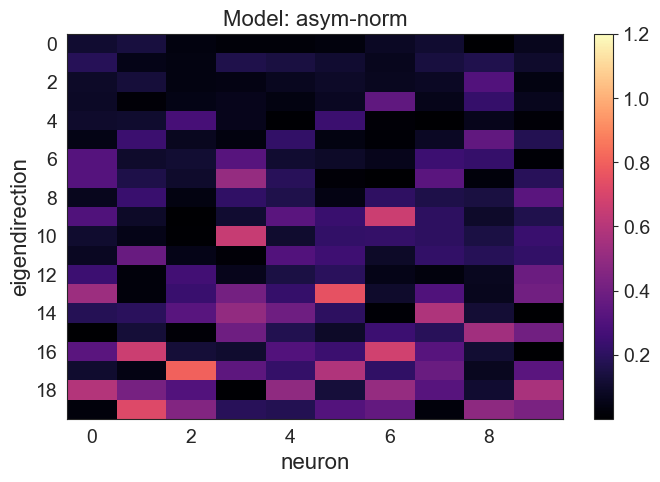

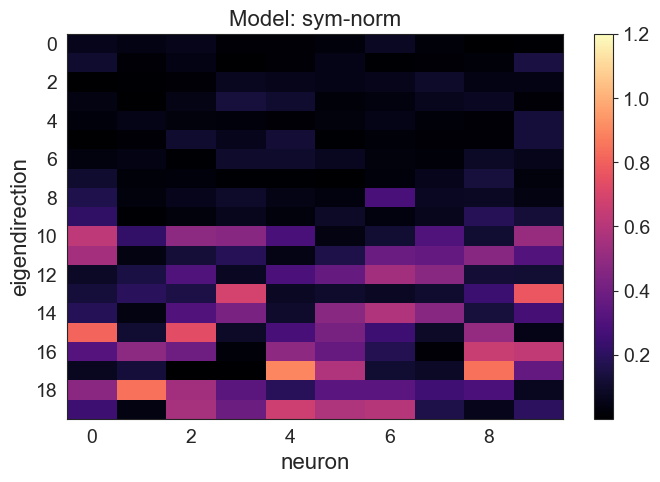

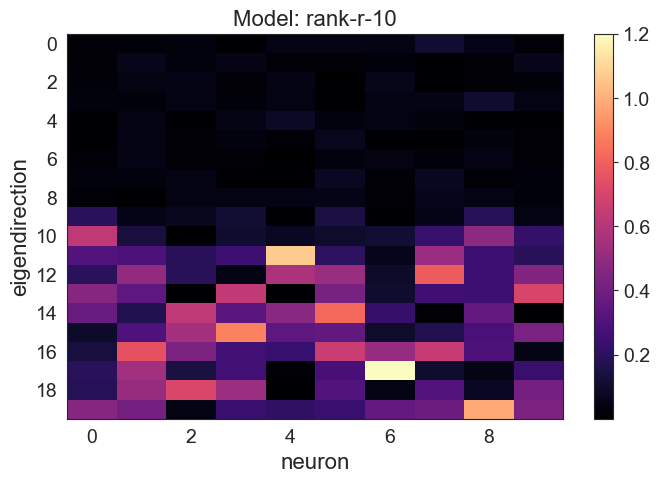

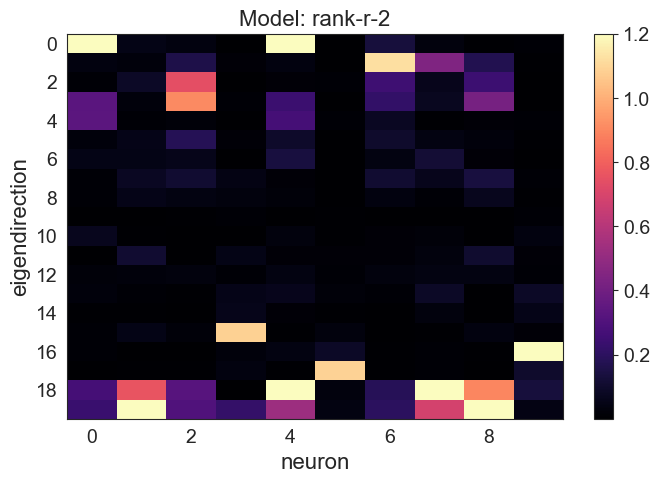

In [153]:
for model, model_name in zip(models[:-2], model_names[:-2]):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Get eigenvectors of Wn for this model
    _eigvals, U = t.linalg.eigh(model.Wn.squeeze())  # **NOTE: Wn not perfectly symmetric...
    
    # Compute dot-product magnitudes between eigenvectors and output weights
    projs = t.abs(U.T @ model.W2.squeeze())  # [feat, hid] dot-product magnitudes
    
    # Create heatmap on the axis
    im = ax.imshow(asnumpy(projs), aspect="auto", cmap="magma", vmax=1.2)
    
    ax.set_yticks(np.arange(0, 20, 2))
    ax.set_xlabel("neuron")
    ax.set_ylabel("eigendirection")
    ax.set_title(f"Model: {model_name}", fontsize=16)
    cbar = fig.colorbar(im, ax=ax)
    
    # Expectation: higher-value but fewer bright streaks = fewer neurons cover many eigen-directions = effectively lower rank = easier to learn

In [28]:
10e-3, 10**-3

(0.01, 0.001)

---

---

## Var explained of PCs of input and output

In [1]:
batch_sz = 16184

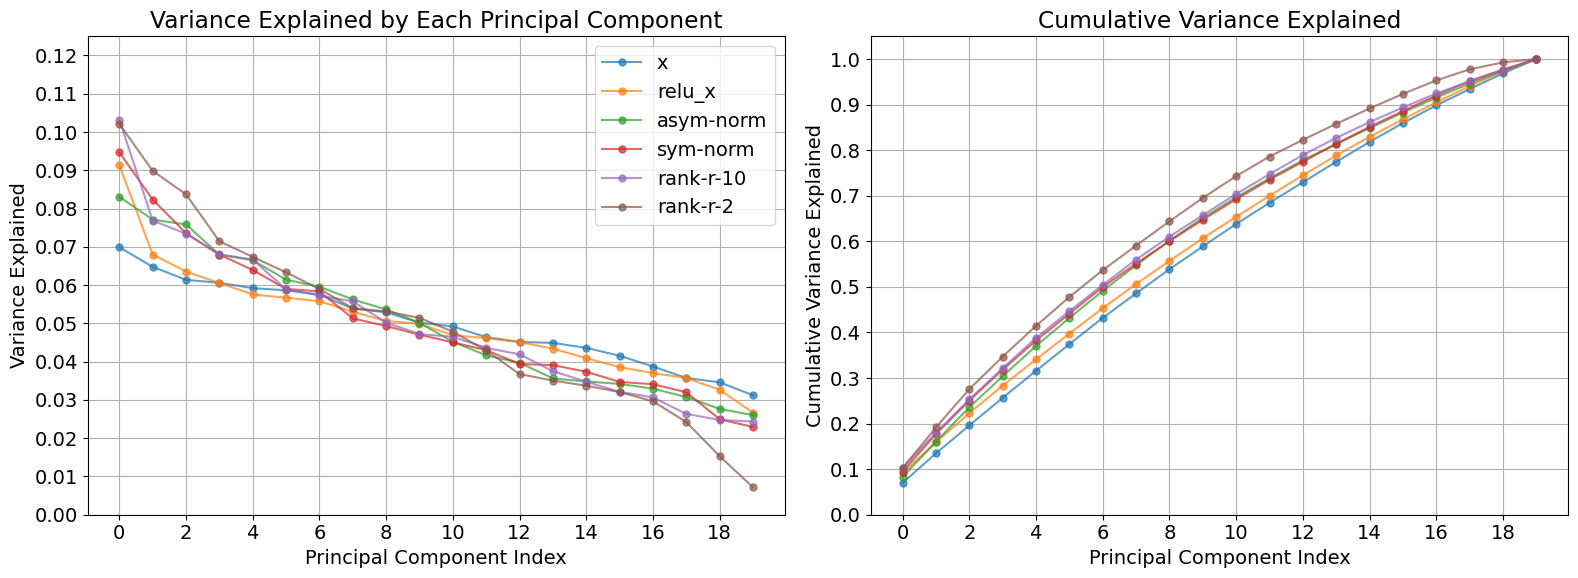

In [ ]:
pc_dict = {}

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for input
x_sv = t.linalg.svdvals(x.squeeze()).sort(descending=True).values
x_var_explained = (x_sv**2) / (x_sv**2).sum()
pc_dict["x"] = x_var_explained

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
pc_dict["relu_x"] = relu_x_var_explained

# Then loop over models and get PC var explained for predicted outputs
for model, model_name in zip(models, model_names):
    # Get predicted output for this model
    with t.no_grad():
        y_pred = model.forward(x)
    
    # Get PC var explained
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    pc_dict[f"{model_name}"] = y_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Regular variance explained per component
for name, var_explained in pc_dict.items():
    ax1.plot(asnumpy(var_explained), label=name, marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Variance Explained")
ax1.set_title("Variance Explained by Each Principal Component")
ax1.set_xticks(np.arange(0, 20, 2))
ax1.set_ylim([0, 0.125])
ax1.set_yticks(np.arange(0, 0.125, 0.01))
ax1.legend()
ax1.grid(True)

# Cumulative variance explained
for name, var_explained in pc_dict.items():
    ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), label=name, marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Cumulative Variance Explained")
ax2.set_title("Cumulative Variance Explained")
ax2.set_yticks(np.arange(0, 1.05, 0.1))
ax2.set_ylim([0, 1.05])
ax2.set_xticks(np.arange(0, 20, 2))
ax2.legend()
ax2.grid(True)

# Add a horizontal line at 0.9 (90% variance explained)
# ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.7)
# ax2.text(0, 0.91, '90% variance', fontsize=10, color='gray')

# plt.tight_layout()
# plt.show()

# # Print the number of PCs needed to explain 90% of variance
# print("Number of PCs needed to explain 90% of variance:")
# for name, var_explained in pc_dict.items():
#     cumulative = t.cumsum(var_explained)
#     n_pcs = t.sum(cumulative < 0.9) + 1  # +1 because we need to include the component that crosses 0.9
#     label = "Input" if name == "input" else "True Output" if name == "true_output" else f"Pred: {name[5:]}"
#     print(f"  {label}: {n_pcs.item()} PCs")

In [ ]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
noise_pc_dict = {}   # For noise matrices

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and noise matrix PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get noise matrix (Wn) variance explained
    wn_sv = t.linalg.svdvals(model.Wn.squeeze()).sort(descending=True).values
    wn_var_explained = (wn_sv**2) / (wn_sv**2).sum()
    noise_pc_dict[f"{model_name}"] = wn_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"Pred: {model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Cumulative Variance Explained")
ax1.set_title("Cumulative Variance Explained: Model Outputs")
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax1.set_ylim([0, 1.05])
ax1.set_xticks(np.arange(0, 20, 2))
ax1.legend()
ax1.grid(True)

# # Right plot: Cumulative variance explained for noise matrices (Wn)
# for model_name in model_names:
#     var_explained = noise_pc_dict[model_name]
#     ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
#              label=f"Noise: {model_name}", marker='o', markersize=5, alpha=0.7)

# ax2.set_xlabel("Principal Component Index")
# ax2.set_ylabel("Cumulative Variance Explained")
# ax2.set_title("Cumulative Variance Explained: Noise Matrices")
# ax2.set_yticks(np.arange(0, 1.05, 0.1))
# ax2.set_ylim([0, 1.05])
# ax2.set_xticks(np.arange(0, 20, 2))
# ax2.legend()
# ax2.grid(True)

# plt.tight_layout()

# # Optionally add horizontal reference lines at 0.9 (90% variance explained)
# ax1.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
# ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)



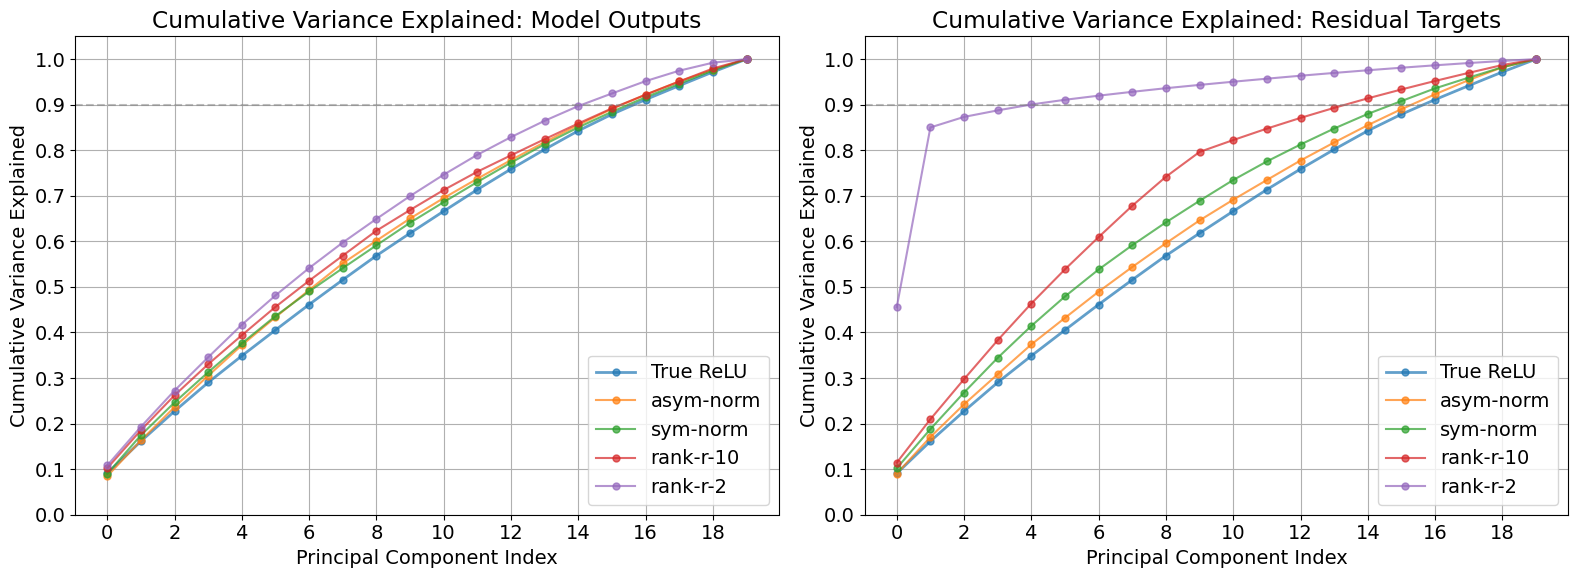

In [31]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
residual_pc_dict = {}  # For residual targets (relu_x - Wnx)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and residual target PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained

# Create cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Cumulative Variance Explained")
ax1.set_title("Cumulative Variance Explained: Model Outputs")
ax1.set_yticks(np.arange(0, 1.05, 0.1))
ax1.set_ylim([0, 1.05])
ax1.set_xticks(np.arange(0, 20, 2))
ax1.legend()
ax1.grid(True)

ax2.plot(asnumpy(t.cumsum(output_pc_dict["relu_x"], dim=0)), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

# Right plot: Cumulative variance explained for residual targets (relu_x - Wnx)
for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax2.plot(asnumpy(t.cumsum(var_explained, dim=0)), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Cumulative Variance Explained")
ax2.set_title("Cumulative Variance Explained: Residual Targets")
ax2.set_yticks(np.arange(0, 1.05, 0.1))
ax2.set_ylim([0, 1.05])
ax2.set_xticks(np.arange(0, 20, 2))
ax2.legend()
ax2.grid(True)

plt.tight_layout()

# Optionally add horizontal reference lines at 0.9 (90% variance explained)
ax1.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

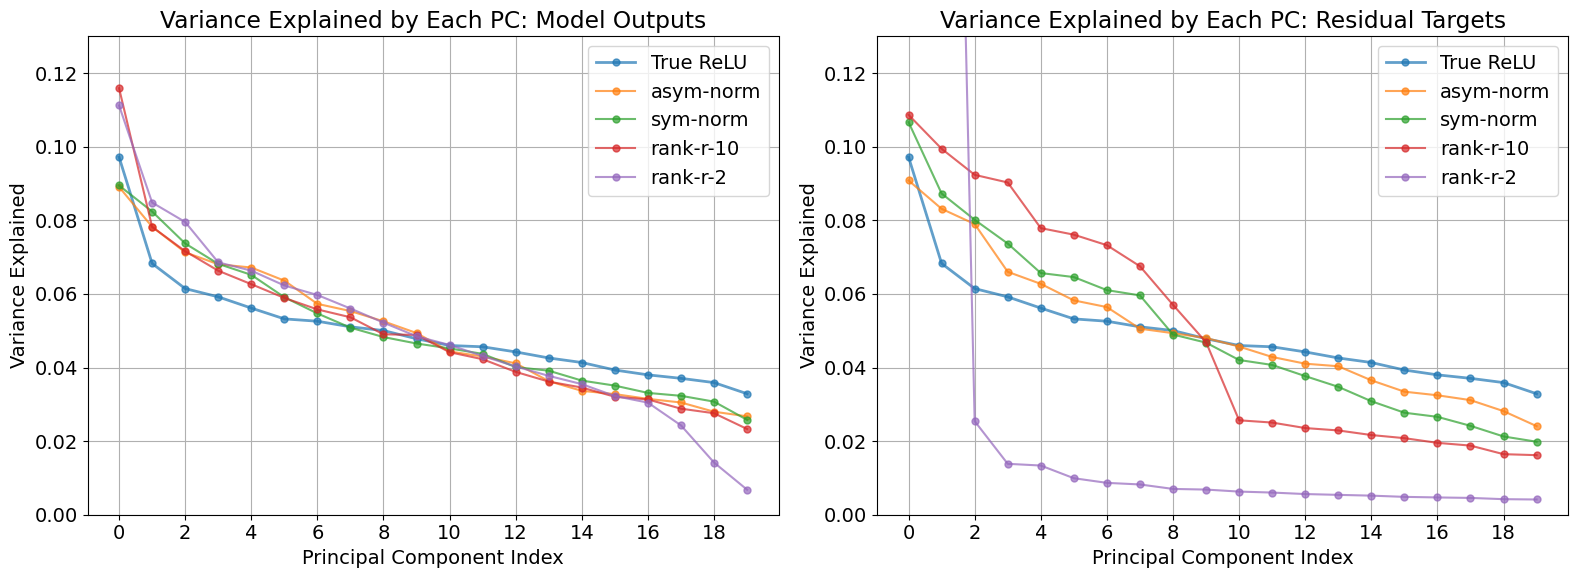

In [34]:
# Create dictionaries to store variance explained data
output_pc_dict = {}  # For model outputs
residual_pc_dict = {}  # For residual targets (relu_x - Wnx)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Loop over models to get both output and residual target PC variance explained
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model and its variance explained
    with t.no_grad():
        y_pred = model.forward(x)
    
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 2. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained

# Create non-cumulative variance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Non-cumulative variance explained for model outputs (true and predicted)
ax1.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax1.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax1.set_xlabel("Principal Component Index")
ax1.set_ylabel("Variance Explained")
ax1.set_title("Variance Explained by Each PC: Model Outputs")
ax1.set_xticks(np.arange(0, 20, 2))
ax1.set_ylim([0, 0.13])  # Adjust based on your data
ax1.legend()
ax1.grid(True)

# Right plot: Non-cumulative variance explained for residual targets (relu_x - Wnx)
ax2.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax2.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax2.set_xlabel("Principal Component Index")
ax2.set_ylabel("Variance Explained")
ax2.set_title("Variance Explained by Each PC: Residual Targets")
ax2.set_xticks(np.arange(0, 20, 2))
ax2.set_ylim([0, 0.13])  # Adjust based on your data
ax2.legend()
ax2.grid(True)

plt.tight_layout()

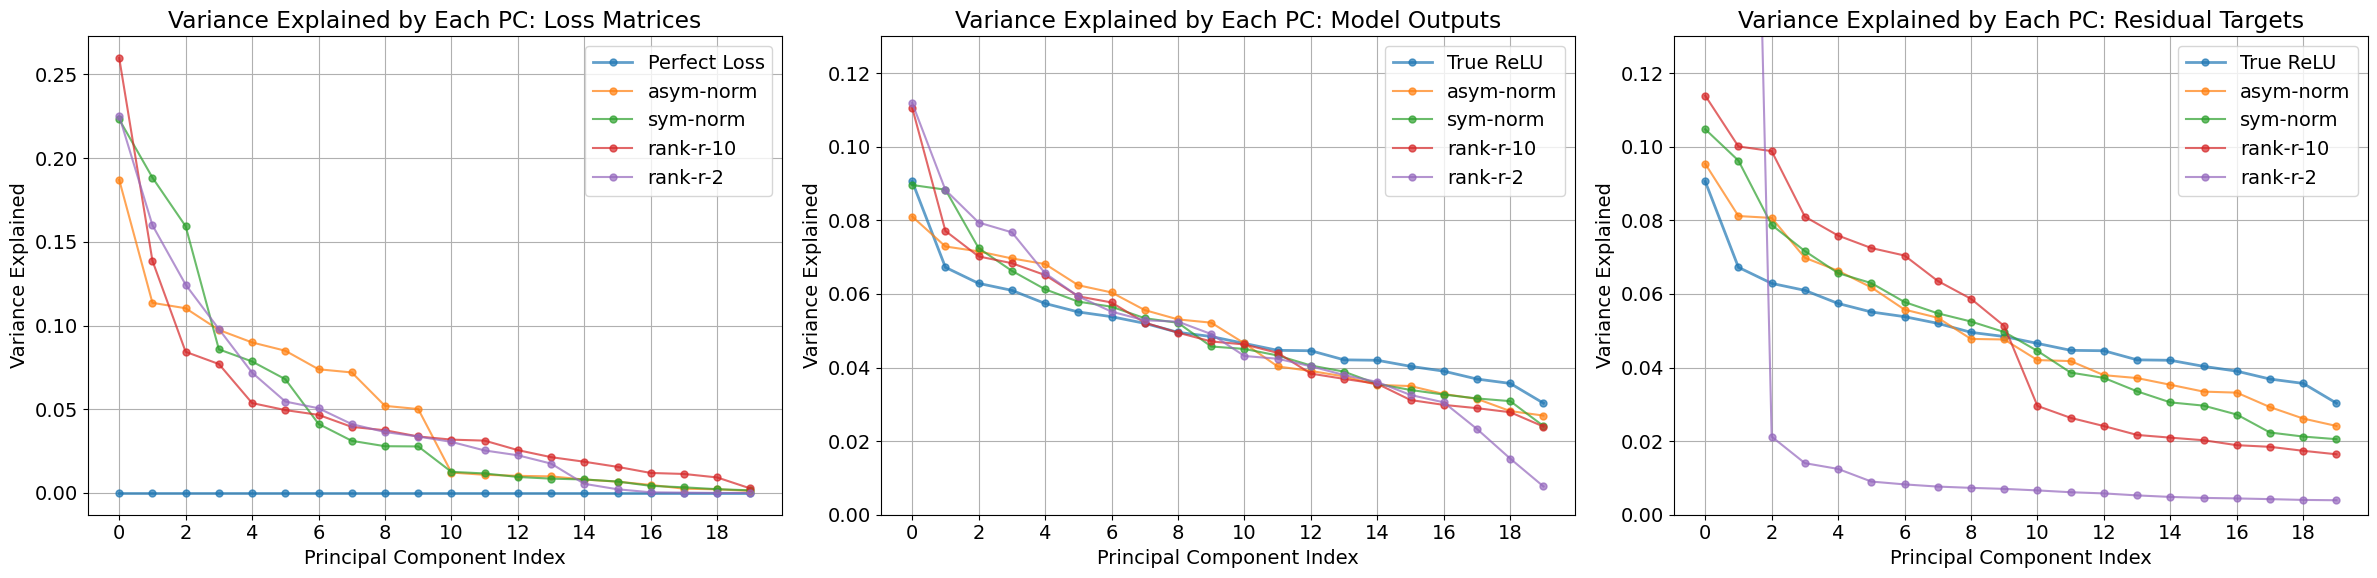

In [36]:
# Create dictionaries to store variance explained data
output_pc_dict = {}     # For model outputs
residual_pc_dict = {}   # For residual targets (relu_x - Wnx)
loss_pc_dict = {}       # For loss matrices (MSE between true and predicted)

models = [cis_asym_norm, cis_sym_norm, cis_rr10, cis_rr2]
model_names = ["asym-norm", "sym-norm", "rank-r-10", "rank-r-2"]

x, relu_x = gen_batch(models[0], 1024, feat_sparsity, device)

# Get PC var explained for true output (ReLU)
relu_x_sv = t.linalg.svdvals(relu_x.squeeze()).sort(descending=True).values
relu_x_var_explained = (relu_x_sv**2) / (relu_x_sv**2).sum()
output_pc_dict["relu_x"] = relu_x_var_explained

# Create a "perfect loss" placeholder for consistent color scheme
loss_pc_dict["perfect"] = t.zeros_like(relu_x_var_explained)

# Loop over models to get variance explained for outputs, residuals, and loss
for model, model_name in zip(models, model_names):
    # 1. Get predicted output for this model
    with t.no_grad():
        y_pred = model.forward(x)
    
    # 2. Calculate variance explained by PCs of model output
    y_sv = t.linalg.svdvals(y_pred.squeeze()).sort(descending=True).values
    y_var_explained = (y_sv**2) / (y_sv**2).sum()
    output_pc_dict[f"{model_name}"] = y_var_explained
    
    # 3. Get residual target (what needs to be learned by W1→W2 path)
    Wnx = einsum(model.Wn, x, "inst feat feat_out, batch inst feat -> batch inst feat_out")
    res_target = relu_x - Wnx
    
    # 4. Calculate variance explained by PCs of residual target
    res_sv = t.linalg.svdvals(res_target.squeeze()).sort(descending=True).values
    res_var_explained = (res_sv**2) / (res_sv**2).sum()
    residual_pc_dict[f"{model_name}"] = res_var_explained
    
    # 5. Calculate MSE loss matrix and its PC variance explained
    loss_matrix = (relu_x - y_pred)**2
    loss_sv = t.linalg.svdvals(loss_matrix.squeeze()).sort(descending=True).values
    loss_var_explained = (loss_sv**2) / (loss_sv**2).sum()
    loss_pc_dict[f"{model_name}"] = loss_var_explained

# Create non-cumulative variance plots in a 1x3 grid
fig, (ax_loss, ax_output, ax_residual) = plt.subplots(1, 3, figsize=(24, 6))

# Left plot: Non-cumulative variance explained for loss matrices
ax_loss.plot(asnumpy(loss_pc_dict["perfect"]), 
         label="Perfect Loss", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = loss_pc_dict[model_name]
    ax_loss.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_loss.set_xlabel("Principal Component Index")
ax_loss.set_ylabel("Variance Explained")
ax_loss.set_title("Variance Explained by Each PC: Loss Matrices")
ax_loss.set_xticks(np.arange(0, 20, 2))
# ax_loss.set_ylim([0, 0.13])
ax_loss.legend()
ax_loss.grid(True)

# Middle plot: Non-cumulative variance explained for model outputs
ax_output.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = output_pc_dict[model_name]
    ax_output.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_output.set_xlabel("Principal Component Index")
ax_output.set_ylabel("Variance Explained")
ax_output.set_title("Variance Explained by Each PC: Model Outputs")
ax_output.set_xticks(np.arange(0, 20, 2))
ax_output.set_ylim([0, 0.13])
ax_output.legend()
ax_output.grid(True)

# Right plot: Non-cumulative variance explained for residual targets
ax_residual.plot(asnumpy(output_pc_dict["relu_x"]), 
         label="True ReLU", marker='o', markersize=5, alpha=0.7, linewidth=2)

for model_name in model_names:
    var_explained = residual_pc_dict[model_name]
    ax_residual.plot(asnumpy(var_explained), 
             label=f"{model_name}", marker='o', markersize=5, alpha=0.7)

ax_residual.set_xlabel("Principal Component Index")
ax_residual.set_ylabel("Variance Explained")
ax_residual.set_title("Variance Explained by Each PC: Residual Targets")
ax_residual.set_xticks(np.arange(0, 20, 2))
ax_residual.set_ylim([0, 0.13])
ax_residual.legend()
ax_residual.grid(True)

plt.tight_layout()

## Effective rank vs. Variance explained tests

With a 20-10 model, start with rank-5 noise_base and init noise_coeff. 
Then clone it, and adjust noise_base so that the top10 PC var explained increases, and the effective rank increases.
Print values for both models.

Then, using these two noise_bases, for 50 runs initialize the two models, train both (training noise_coeff), evaluate their loss, and save in df, with one row per run, and one col per model.

Create box + strip plots of the losses.

### Create models

In [5]:
def effective_rank(matrix: t.Tensor) -> float:
    """Computes the effective rank of a matrix as exp(entropy(normalized singular values))."""
    assert matrix.dim() == 2, "Input must be a 2D tensor"
    
    singular_vals = t.linalg.svdvals(matrix)
    singular_val_dist = singular_vals / singular_vals.sum()
    entropy = -t.sum(singular_val_dist * singular_val_dist.log())
    
    return t.exp(entropy).item()

In [6]:
def explained_variance(matrix: t.Tensor, k: int) -> float:
    """Computes the explained variance of a matrix as the sum of squared singular values."""
    assert matrix.dim() == 2, "Input must be a 2D tensor"
    
    vars = t.linalg.svdvals(matrix)**2
    return (vars[:k].sum() / vars.sum()).item()

In [ ]:
def tweak_matrix(
    A: t.Tensor,
    topk: int = 10,  # number of top singular values to bump up
    bottomk: int = 10,  # number of bottom singular values to bump up
    d_var: float = 0.05,  # % variance explained increase
    d_er: float = 0.05,  # % effective rank increase
    alphas: t.Tensor = None,  # grid of a values
    gammas: t.Tensor = None,  # grid of y values
):
    """Iteratively tweaks a matrix to increase its effective rank and topk PC variance.

    Scales `A`'s topk singular values by a>1 and the bottomk by y>1, searching a small 
    2-D grid for the first pair that hits both targets:
    1. var_explained over topk increases by >= d_var
    2. eff-rank of entire matrix increases by >= d_er
    
    Returns A' and a dict of diagnostics.
    """
    # Grid over a, y  (a boosts top-k, y boosts tail)
    alphas = t.linspace(1.01, 10, 30) if alphas is None else alphas
    gammas = t.linspace(1.01, 10, 30) if gammas is None else gammas

    U, S, Vh = t.linalg.svd(A, full_matrices=False)
    base_var = explained_variance(A, topk)
    base_er  = effective_rank(A)
    var_goal = base_var * (1 + d_var)
    er_goal  = base_er  * (1 + d_er)

    best = None
    best_frob = 1e9

    for a in alphas:
        for y in gammas:
            S_new = S.clone()
            S_new[:topk] *= a.item()
            S_new[-bottomk:] *= y.item()

            # Re-assemble only if goals met
            A_new = (U * S_new) @ Vh
            v_now = explained_variance(A_new, topk)
            e_now = effective_rank(A_new)

            # print(f"{v_now=:.3f}, {e_now=:.3f}, {a=:.3f}, {y=:.3f}")
            if v_now >= var_goal and e_now >= er_goal:
                frob_change = (S_new - S).pow(2).sum().sqrt().item()
                if frob_change < best_frob:   # keep smallest perturbation
                    best_frob = frob_change
                    best = (A_new, v_now, e_now, a.item(), y.item())

    if best is None:
        raise RuntimeError("No (a, y) pair hit both targets; widen search.")

    A_new, v_now, e_now, a, y = best
    return A_new, {
        "var_base": base_var,
        "er_base":  base_er,
        "var_new'": v_now,
        "er_new'": e_now,
        "alpha": a,
        "gamma": y,
        "d_Frobenius": best_frob,
    }

In [31]:
n_feat = 20
n_hidden = 10
r = 7
noise_coeff = 0.5

In [36]:
# Create "effective rank" model
layer_act_fns = [t.relu, lambda x: x]
noise_params = {
    "matrix_type": "rank-r",  # "asymmetric", "rank-r"
    "noise_coeff": noise_coeff,
    "r": r,
    "learned": True
}
eff_rank_cis = CisConfig(
    n_instances=1,
    n_feat=n_feat,
    n_hidden=n_hidden,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    noise_params=noise_params,
)
eff_rank_cis = Cis(eff_rank_cis, device=device).to(device)

# print var explained and effective rank of noise_base by top `n_hidden` PCs
Wn = eff_rank_cis.noise_base[0]
eff_rank_cis_var_expl = explained_variance(Wn, n_hidden)
eff_rank_cis_eff_rank = effective_rank(Wn)
print(f"{eff_rank_cis_var_expl=:.3f}, \n{eff_rank_cis_eff_rank=:.3f}")

eff_rank_cis_var_expl=0.801, 
eff_rank_cis_eff_rank=18.021


In [58]:
# Create "variance explained" model -- bump up var_expl and eff_rank
var_expl_cis = copy.deepcopy(eff_rank_cis)
Wn_new, tweak_metrics = tweak_matrix(
    Wn,
    topk = n_hidden,
    bottomk = 5,
    d_var = 0.011,
    d_er = 0.011,
    alphas = t.linspace(1.1, 1.5, 30),
    gammas = t.linspace(1.1, 1.7, 30)
)

var_expl_cis.noise_base.data = Wn_new.expand(1, -1, -1)
var_expl_cis_var_expl = explained_variance(Wn_new, n_hidden)
var_expl_cis_eff_rank = effective_rank(Wn_new)
print(f"\n\n{var_expl_cis_var_expl=:.3f}, \n{var_expl_cis_eff_rank=:.3f}")
print(tweak_metrics)

v_now=0.822, e_now=17.914, a=1.100, y=1.100
v_now=0.821, e_now=17.944, a=1.100, y=1.121
v_now=0.819, e_now=17.974, a=1.100, y=1.141
v_now=0.818, e_now=18.003, a=1.100, y=1.162
v_now=0.816, e_now=18.031, a=1.100, y=1.183
v_now=0.815, e_now=18.059, a=1.100, y=1.203
v_now=0.813, e_now=18.085, a=1.100, y=1.224
v_now=0.811, e_now=18.112, a=1.100, y=1.245
v_now=0.810, e_now=18.137, a=1.100, y=1.266
v_now=0.808, e_now=18.162, a=1.100, y=1.286
v_now=0.806, e_now=18.187, a=1.100, y=1.307
v_now=0.805, e_now=18.211, a=1.100, y=1.328
v_now=0.803, e_now=18.234, a=1.100, y=1.348
v_now=0.801, e_now=18.257, a=1.100, y=1.369
v_now=0.799, e_now=18.279, a=1.100, y=1.390
v_now=0.798, e_now=18.301, a=1.100, y=1.410
v_now=0.796, e_now=18.322, a=1.100, y=1.431
v_now=0.794, e_now=18.342, a=1.100, y=1.452
v_now=0.792, e_now=18.362, a=1.100, y=1.472
v_now=0.790, e_now=18.382, a=1.100, y=1.493
v_now=0.788, e_now=18.401, a=1.100, y=1.514
v_now=0.786, e_now=18.420, a=1.100, y=1.534
v_now=0.785, e_now=18.438, a=1.1

### Train models

In [59]:
eff_rank_cis0 = copy.deepcopy(eff_rank_cis)
var_expl_cis0 = copy.deepcopy(var_expl_cis)

In [60]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(
    model: Cis,
    batch_sz: int, 
    sparsity: float | Float[Tensor, "inst feat"],
    device: t.device
) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x) + x

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
    device: t.device
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.6f}"})
    
    return losses

@t.no_grad()
def eval_model(
    model: Cis, 
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    n_batches: int,
    device: t.device
):
    losses = t.zeros(n_batches)
    
    for b in range(n_batches):
        x, y_true = gen_batch(model, batch_sz, feat_sparsity, device)
        y = model.forward(x)
        losses[b] = loss_fn(y, y_true, 1)
    
    return losses

For `n_runs`, train copies of both models, eval both models, and save the mean losses in a dataframe.
with columns for each model, and rows for each run.

In [76]:
results_df = pd.DataFrame(columns=["eff_rank_loss", "var_expl_loss"])

In [ ]:
n_runs = 50
feat_sparsity = 0.9
batch_sz = 1024
n_steps = 7500  # reduced from 10000 for faster runs
logging_freq = n_steps // 10

pbar = tqdm(range(n_runs), desc="Running experiments")

for run in pbar:
    
    # Reset models to initial state for each run
    eff_rank_model = copy.deepcopy(eff_rank_cis0)
    var_expl_model = copy.deepcopy(var_expl_cis0)
    
    # Optimizer for effective rank model
    eff_rank_opt = optim.Adam(eff_rank_model.parameters(), lr=1e-3)
    
    # Optimizer for variance explained model
    var_expl_opt = optim.Adam(var_expl_model.parameters(), lr=1e-3)
    
    # Train effective rank model
    _ = train(
        model=eff_rank_model,
        batch_sz=batch_sz,
        feat_sparsity=feat_sparsity,
        feat_importance=1.0,
        loss_fn=loss_fn,
        optimizer=eff_rank_opt,
        n_steps=n_steps,
        logging_freq=logging_freq,
        device=device,
    )
    
    # Train variance explained model
    _ = train(
        model=var_expl_model,
        batch_sz=batch_sz,
        feat_sparsity=feat_sparsity,
        feat_importance=1.0,
        loss_fn=loss_fn,
        optimizer=var_expl_opt,
        n_steps=n_steps,
        logging_freq=logging_freq,
        device=device,
    )
    
    # Evaluate effective rank model
    eff_rank_losses = eval_model(
        eff_rank_model, 
        batch_sz=100000,
        feat_sparsity=feat_sparsity,
        n_batches=100,
        device=device
    )
    
    # Evaluate variance explained model
    var_expl_losses = eval_model(
        var_expl_model, 
        batch_sz=100000,
        feat_sparsity=feat_sparsity,
        n_batches=100,
        device=device
    )

    new_row = pd.DataFrame({
        "eff_rank_loss": [eff_rank_losses.mean().item()],
        "var_expl_loss": [var_expl_losses.mean().item()]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

Running experiments:   0%|          | 0/48 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

Training:   0%|          | 0/7500 [00:00<?, ?it/s]

In [82]:
# Display summary statistics
print("\nResults Summary:")
print(results_df.describe())



Results Summary:
       eff_rank_loss  var_expl_loss
count      50.000000      50.000000
mean        0.007037       0.007123
std         0.000013       0.000010
min         0.007016       0.007102
25%         0.007029       0.007119
50%         0.007034       0.007122
75%         0.007043       0.007125
max         0.007073       0.007173



Mann-Whitney U test: U-statistic=0.0000, p-value=0.0000
Mean difference: -0.000086


C:\Users\jai\AppData\Local\Temp\ipykernel_26808\3939433059.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\jai\AppData\Local\Temp\ipykernel_26808\3939433059.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\jai\AppData\Local\Temp\ipykernel_26808\3939433059.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["low-er, low-ve", "high-er, high-ve"])  # Custom x-axis labels


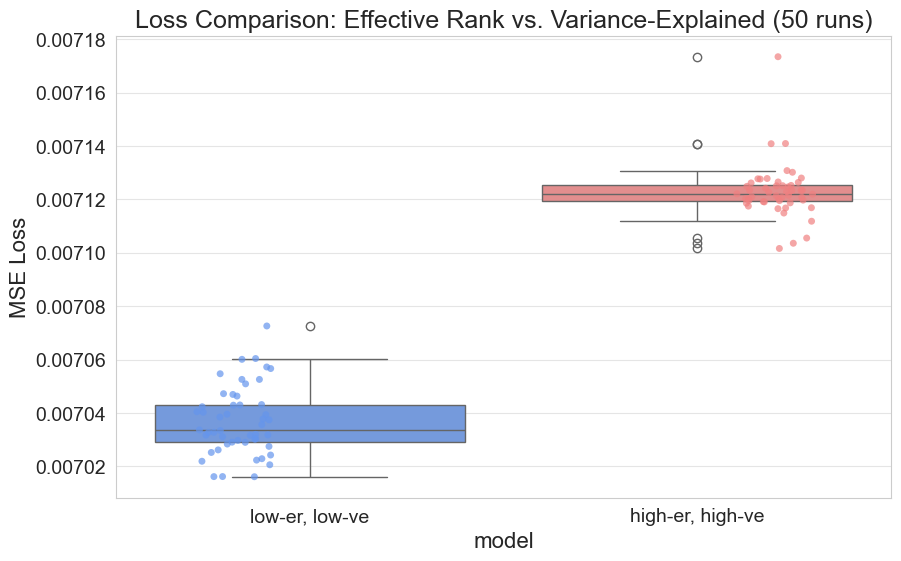

In [85]:
# Create box plot with strip plot overlay using OO approach
fig, ax = plt.subplots(figsize=(10, 6))

# Create melted dataframe for plotting
melted_df = pd.melt(
    results_df,
    value_vars=["eff_rank_loss", "var_expl_loss"],
    var_name="model", 
    value_name="loss"
)

# Define colors for each model
colors = {"eff_rank_loss": "cornflowerblue", "var_expl_loss": "lightcoral"}

# Create the box plot with different colors
sns.boxplot(
    data=melted_df, 
    x="model", 
    y="loss", 
    ax=ax,
    palette=colors
)

# Add strip plot over the box plot with same colors but offset
sns.stripplot(
    data=melted_df,
    x="model",
    y="loss",
    ax=ax,
    palette=colors,
    dodge=True,  # Add offset from center of boxplot
    alpha=0.7,
    jitter=0.2   # Add some jitter for better visibility
)

# Customize the plot
ax.set_title(f"Loss Comparison: Effective Rank vs. Variance-Explained (50 runs)")
ax.set_ylabel("MSE Loss")
ax.grid(axis="y", alpha=0.5)
ax.set_xticklabels(["low-er, low-ve", "high-er, high-ve"])  # Custom x-axis labels

# fig.tight_layout()

# Perform Mann-Whitney U test instead of t-test
u_stat, p_value = mannwhitneyu(
    results_df["eff_rank_loss"], 
    results_df["var_expl_loss"],
    alternative='two-sided'  # Use two-sided test to detect differences in either direction
)
print(f"\nMann-Whitney U test: U-statistic={u_stat:.4f}, p-value={p_value:.4f}")
print(f"Mean difference: {(results_df['eff_rank_loss'] - results_df['var_expl_loss']).mean():.6f}")